# Compare smoothed waveforms

Experimental/simulation data have already been processed into time series of smoothed harmonics.

Settings.inp constains parameters for this script as well as the harmonic splitter used to get the smoothed harmonics.

This script should not need to be modified by general users. All done via the settings.inp file which is created by the "GenerateScript" python notebook.

There is a plotting option at the bottom of this script that can be activated manually - leave turned off for running with the bash script.

### Note:

At present the least squares contribution from all harmonics (inc dc) are weighted equally. This will be changed in future versions.


## Script parameters

In [67]:
# output to screen (useful if interactive)
iOutputToScreen = True
# output plots to screen (useful if interactive)
plotInteractive = True
# default to non script mode 
# (corrected later if this is called from script.sh)
iScriptMode = False

### Load packages

In [68]:
import numpy as np
import sys

## Simulation or experiment inputs

Take arguments from command line

In [69]:
if(len(sys.argv)>1):
    if(sys.argv[1]=='-script'):
        iScriptMode = True
        iOutputToScreen = False
        plotInteractive = False
        input_parameters = []
        if(len(sys.argv)>2):
            input_parameters = sys.argv[2:]

## Read settings

input the total number of frequencies to check; i.e. all frequencies, harmonics, cross harmonics etc
specified in harmonic splitter when this was created

weights file (made by generate script?)

In [70]:
lines = [line.rstrip('\n') for line in open('Settings.inp')]
raw_data_exp = lines[0].strip().split()[0]
raw_data_sim = lines[1].strip().split()[0]
number_harmonics = int(lines[2].strip().split()[0])
frequency_bandwidth = float(lines[3].strip().split()[0])
filename_exp = lines[4].strip().split()[0]
filename_sim = lines[5].strip().split()[0]
results_name = lines[6].strip().split()[0]

## Output summary to screen

In [71]:
if(iOutputToScreen):
    print "Experiment file: ", filename_exp
    print "Simulation file: ", filename_sim

Experiment file:  ExpSmoothed.txt
Simulation file:  Smoothed.txt


## Define functions

Read smoothed time series data. Generalise to take any number of harmonics and weights.
For example we have 2 input frequencies and the 2nd harmonic of the 1st input frequency is more important.
Default is all equally weighted.

Generally, i=0 is the dc componet, others are harmonics. But does not have to be.

In [72]:
def ReadSmoothed(filename):
    lines = [line.rstrip('\n') for line in open(filename)]
    n_rows = len(lines)
    n_cols = len(lines[0].strip().split())
    n_harm = n_cols - 1
    n_elements = n_harm * n_rows
    i_harm = np.zeros((n_harm, n_rows))
    time = []
    for i in range(n_rows):
        time.append(float(lines[i].strip().split()[0]))
        for j in range(1, n_harm+1):
            i_harm[j-1, i] = float(lines[i].strip().split()[j])
    return n_rows, n_harm, time, i_harm

Simple least squares function scaled by the sum of squares of the first input function - used for comparison. 

Combine these by weights to get the final metric.

This assumes that they perfectly align (they do on the test case and rest made by MECSim so should too)

In [73]:
def LeastSquares(y1, y2): # first is the basis for comparision
    S = 0.0
    X = 0.0
    for i in range(len(y1)):
        S += (y1[i]-y2[i])**2.
        X += y1[i]**2.
    return S/X

## Read files

Set experimental and simulation files for comparison

In [74]:
# experiment file for basis
n_rows_exp, n_harm_exp, t_exp, i_Harm_exp = ReadSmoothed(filename_exp)

# simulation file for comparison
n_rows_sim, n_harm_sim, t_sim, i_Harm_sim = ReadSmoothed(filename_sim)

These should match up

In [75]:
if(iOutputToScreen):
    if(n_harm_exp!=n_harm_sim):
        print "Number of harmonics does not match"
    if(n_rows_exp!=n_rows_sim):
        print "Number of rows in smoothed data does not match"
n_harm = n_harm_exp

## Calculate metric

Calculate least squares for each harmonic

In [76]:
S = np.zeros(n_harm)
for i in range(n_harm):
    # first is comparison basis
    S[i] = LeastSquares(i_Harm_exp[i,], i_Harm_sim[i ,]) 

Combine with weights (if specified) to give final, single valued metric

In [77]:
Smetric = 0.0
for i in range(n_harm):
    Smetric+=S[i]
if(iOutputToScreen):
    print "Least squares vector = ", S
    print "S metric = ", Smetric

Least squares vector =  [ 0.34148916  0.49130412  0.89570379  0.44144799  0.79128016  0.58996113
  0.44219087]
S metric =  3.99337721948


## Write to summary results file

Append to the results file if in script mode. Note that the results file must already exist. The script will automatically make an empty file when it begins.

In [78]:
if(iScriptMode):
    import csv
    input_parameters_float = [ float(x) for x in input_parameters ]
    results_line = input_parameters_float + [Smetric]
    with open(results_name,'a') as f:
        writer = csv.writer(f)
        writer.writerow(results_line)

## Use interactive plotter

ONLY if not using this in bash script.

Note that the dc component can contain spurious spikes depending on where the value of the maximum frequency cut off. This frequency is set by the lowest fundamental frequency of the applied ac voltage, which can be a problem if it is very low.

Check that any spikes are artifacts of the frequency cut off by examining the raw data using "MECSimPlotter.ipynb"

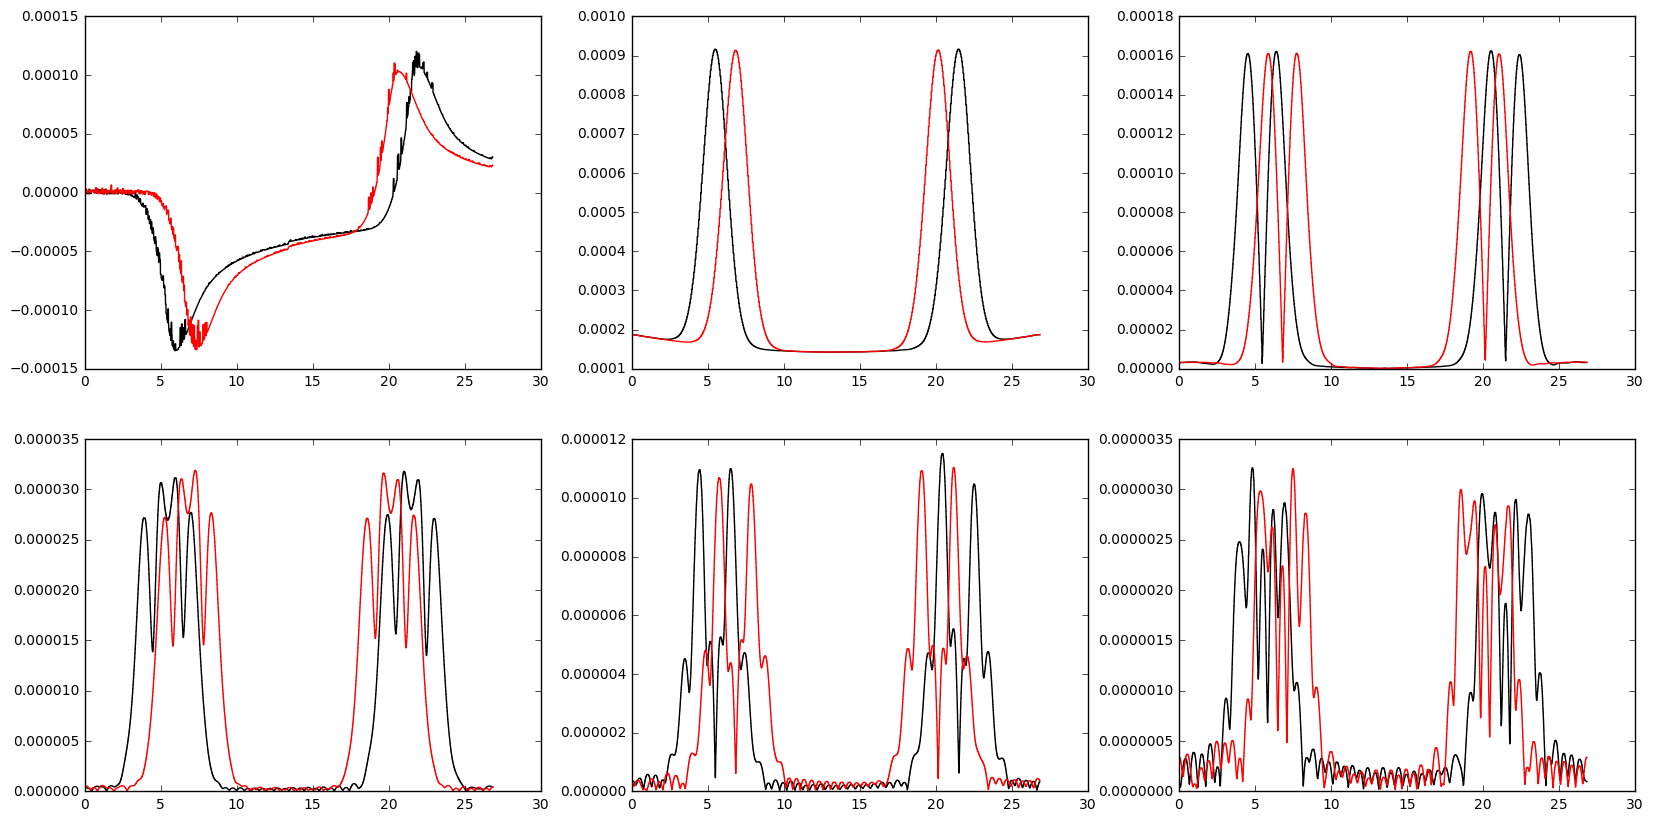

In [79]:
if(plotInteractive):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(20,10))
    plt.subplot(231)
    plt.plot(t_sim, i_Harm_sim[0 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[0 ,], c='r')
    plt.subplot(232)
    plt.plot(t_sim, i_Harm_sim[1 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[1 ,], c='r')
    plt.subplot(233)
    plt.plot(t_sim, i_Harm_sim[2 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[2 ,], c='r')
    plt.subplot(234)
    plt.plot(t_sim, i_Harm_sim[3 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[3 ,], c='r')
    plt.subplot(235)
    plt.plot(t_sim, i_Harm_sim[4 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[4 ,], c='r')
    plt.subplot(236)
    plt.plot(t_sim, i_Harm_sim[5 ,], c='k')
    plt.plot(t_exp, i_Harm_exp[5 ,], c='r')
    plt.show()